# A Jupyter notebook for analyzing PyPSA network data
This notebook includes analysis of transmission lines, loading, losses, and unserved load.

## Import Required Libraries
Import necessary libraries such as PyPSA, pandas, matplotlib, and others for data analysis and visualization.

In [1]:
# Import Required Libraries
import pypsa
import pandas as pd
import matplotlib.pyplot as plt
import warnings

## Load PyPSA Network
Load the PyPSA network file (e.g., 'elec_s_all_ec_lcopt_1h.nc') and display basic information about the network.

In [2]:
# Load the PyPSA network
network_path = "C:/Users/hie/pe_tan/pypsa-earth/results/2040_base/networks/elec_s_all_ec_lcopt_1h.nc"
n = pypsa.Network(network_path)

# Display basic network information
print(n)

INFO:pypsa.io:Imported network elec_s_all_ec_lcopt_1h.nc has buses, carriers, generators, lines, loads, storage_units


PyPSA Network 'PyPSA-Earth'
Components:
 - Bus: 67
 - Carrier: 14
 - Generator: 246
 - Line: 73
 - Load: 67
 - StorageUnit: 16
Snapshots: 8760


## Transmission Line Summary
Analyze and summarize transmission line data, including total capacity, length, and descriptive statistics.

In [3]:
# Transmission Line Summary
print("=== Transmission Line Summary ===")
print(n.lines[["bus0", "bus1", "length", "s_nom"]].describe())

# Total line capacity
total_capacity = n.lines.s_nom.sum()
print(f"Total transmission capacity (AC lines): {total_capacity:.2f} MVA")

# Total length
total_length = n.lines.length.sum()
print(f"Total transmission length: {total_length:.2f} km")

=== Transmission Line Summary ===
           length        s_nom
count   73.000000    73.000000
mean    95.565374   476.322039
std     67.377264   463.888878
min      6.815345    53.728216
25%     41.215116   147.466806
50%     69.749162   491.556019
75%    143.853832   491.556019
max    267.416307  1787.476433
Total transmission capacity (AC lines): 34771.51 MVA
Total transmission length: 6976.27 km


## Line Loading Analysis
Calculate and visualize line loading, including maximum and average utilization ratios, and identify the most congested lines.

=== Line Loading Summary ===
Max line loading: 834.18%
Average line loading: 137.86%


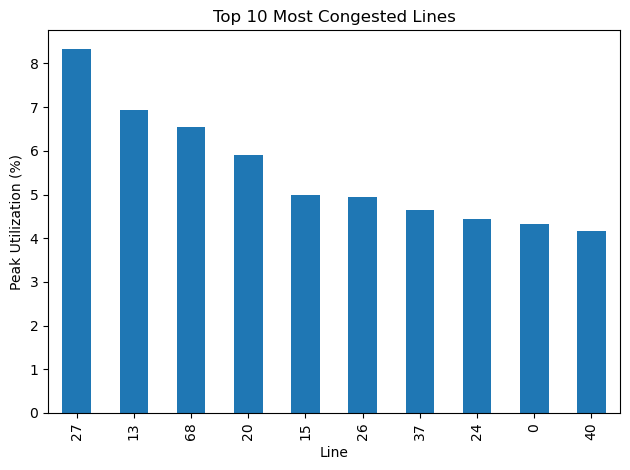

In [4]:
# Line Loading Analysis
line_loading = abs(n.lines_t.p0) / n.lines.s_nom  # Utilization ratio
max_loading = line_loading.max()
avg_loading = line_loading.mean()

print("=== Line Loading Summary ===")
print(f"Max line loading: {max_loading.max():.2%}")
print(f"Average line loading: {avg_loading.mean():.2%}")

# Plot top 10 most congested lines
top_congested = line_loading.max().sort_values(ascending=False).head(10)
top_congested.plot(kind='bar', title='Top 10 Most Congested Lines')
plt.ylabel("Peak Utilization (%)")
plt.tight_layout()
plt.show()

## Line Shadow Prices
Check for the availability of shadow prices and display their summary if available.

In [5]:
# Line Shadow Prices
print("=== Line Shadow Prices (if available) ===")
if hasattr(n, "line_constraints_dual"):
    shadow_prices = n.line_constraints_dual  # dual prices on thermal limits
    print(shadow_prices.describe())
else:
    print("Shadow prices not available (run LOPF with duals enabled).")

=== Line Shadow Prices (if available) ===
Shadow prices not available (run LOPF with duals enabled).


## Transmission Losses
Estimate and analyze transmission losses using I²R calculations and visualize the top lines by average losses.

Total transmission losses over the modelled period: 0.00 MWh


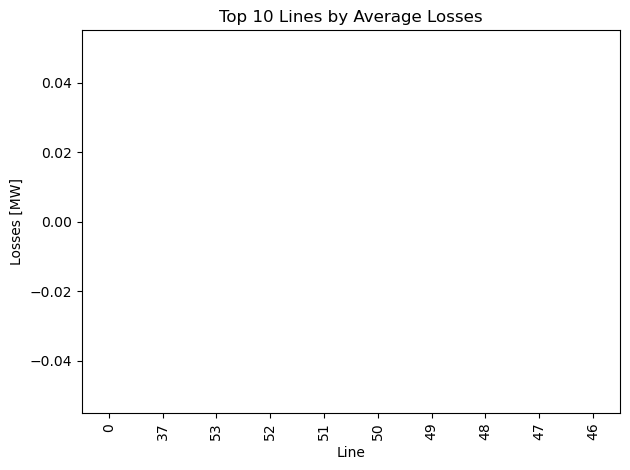

In [6]:
# Transmission Losses
losses = abs(n.lines_t.p0 + n.lines_t.p1)  # p0 + p1 ≈ line loss
total_losses = losses.sum().sum()
print(f"Total transmission losses over the modelled period: {total_losses:.2f} MWh")

# Plot average losses by line
avg_losses = losses.mean().sort_values(ascending=False).head(10)
avg_losses.plot(kind="bar", title="Top 10 Lines by Average Losses")
plt.ylabel("Losses [MW]")
plt.tight_layout()
plt.show()

## Impedance Parameters
Summarize impedance parameters (resistance and reactance) for the transmission lines.

In [7]:
# Impedance Parameters
print("=== Impedance Parameters (r, x, type) ===")
print(n.lines[["r", "x", "type"]].describe())

=== Impedance Parameters (r, x, type) ===
               r           x
count  73.000000   73.000000
mean   17.880629  146.621154
std    17.749205  145.543484
min     0.966756    7.927396
25%     4.983448   40.864278
50%    13.573114  111.299533
75%    22.398451  183.667297
max    85.493122  701.043598


## Unserved Load Analysis
Analyze unserved load due to grid constraints and visualize the buses with the highest unserved load.

Total unserved load (due to congestion or generation limits): 0.00 MWh


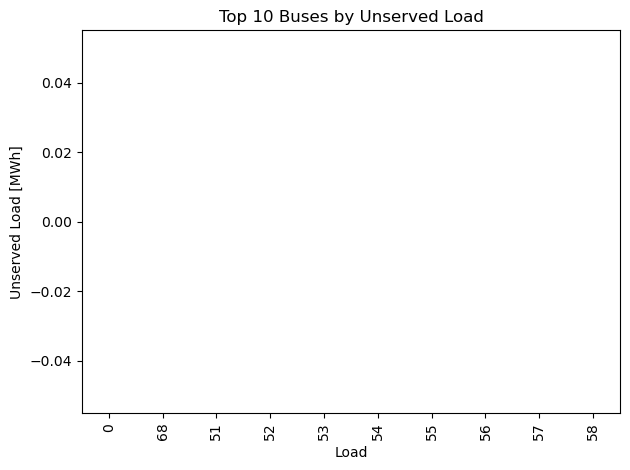

In [8]:
# Unserved Load Analysis
load_diff = n.loads_t.p_set - n.loads_t.p
total_unserved = load_diff.clip(lower=0).sum().sum()
print(f"Total unserved load (due to congestion or generation limits): {total_unserved:.2f} MWh")

# Plot buses with most lost load
lost_load_by_bus = load_diff.clip(lower=0).sum(axis=0).sort_values(ascending=False).head(10)
lost_load_by_bus.plot(kind="bar", title="Top 10 Buses by Unserved Load")
plt.ylabel("Unserved Load [MWh]")
plt.tight_layout()
plt.show()

## Congestion vs. Unserved Load Correlation
Investigate the correlation between congestion and unserved load, and visualize the relationship using scatter plots.

                lost_load  max_congestion
lost_load             NaN             NaN
max_congestion        NaN             1.0


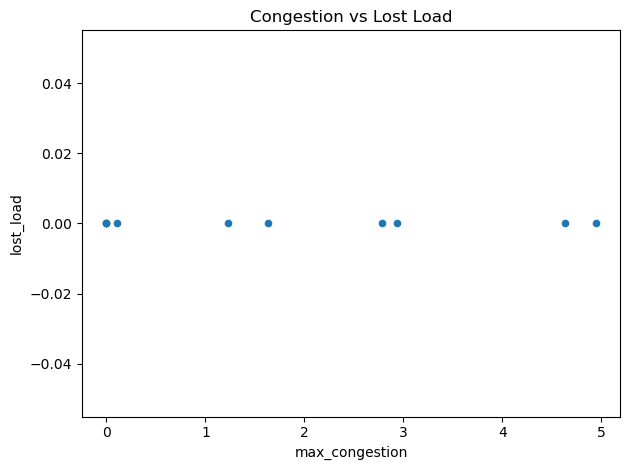

In [9]:
# Congestion vs. Unserved Load Correlation
bus_congestion = pd.Series(0, index=n.buses.index, dtype=float)

# Assign congestion to buses (rough proxy)
for line in line_loading.columns:
    b0 = n.lines.at[line, "bus0"]
    b1 = n.lines.at[line, "bus1"]
    value = line_loading[line].max()
    bus_congestion[b0] = max(bus_congestion[b0], value)
    bus_congestion[b1] = max(bus_congestion[b1], value)

# Merge and correlate
merged = pd.DataFrame({
    "lost_load": lost_load_by_bus,
    "max_congestion": bus_congestion.reindex(lost_load_by_bus.index, fill_value=0)
})

print(merged.corr())

# Optional scatter plot
merged.plot.scatter(x="max_congestion", y="lost_load", title="Congestion vs Lost Load")
plt.tight_layout()
plt.show()

## Component Summary
List the number of components by type in the PyPSA network, such as buses, carriers, generators, and lines.

In [10]:
# Component Summary
for c in n.iterate_components(list(n.components.keys())[2:]):
    print("Component '{}' has {} entries".format(c.name, len(c.df)))

Component 'Bus' has 67 entries
Component 'Carrier' has 14 entries
Component 'Line' has 73 entries
Component 'LineType' has 34 entries
Component 'TransformerType' has 14 entries
Component 'Load' has 67 entries
Component 'Generator' has 246 entries
Component 'StorageUnit' has 16 entries


In [ ]:

# # Flow Plot Example
# # Here, we are going to import a network and plot the electricity flow

# import warnings

# import cartopy.crs as ccrs
# import matplotlib.pyplot as plt
# import pandas as pd
# from shapely.errors import ShapelyDeprecationWarning

# import pypsa

# warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)
# plt.rc("figure", figsize=(10, 8))
# #Import and optimize a network
# n = pypsa.examples.ac_dc_meshed(from_master=True)
# n.optimize()
# #Get mean generator power by bus and carrier:

# gen = n.generators.assign(g=n.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum()
# #Plot the electricity flows:

# # links are not displayed for prettier output ('link_widths=0')
# n.plot(
#     bus_sizes=gen / 5e3,
#     bus_colors={"gas": "indianred", "wind": "midnightblue"},
#     margin=0.5,
#     line_widths=0.1,
#     line_flow="mean",
#     link_widths=0,
# )
# plt.show()
# #Plot the electricity flows with a different projection and a colored map:

# # links are not displayed for prettier output ('link_widths=0')
# n.plot(
#     bus_sizes=gen / 5e3,
#     bus_colors={"gas": "indianred", "wind": "midnightblue"},
#     margin=0.5,
#     line_widths=0.1,
#     line_flow="mean",
#     link_widths=0,
#     projection=ccrs.EqualEarth(),
#     color_geomap=True,
# )
# plt.show()
# #Set arbitrary values as flow argument using a specific level from the n.branches() MultiIndex:

# line_flow = pd.Series(10, index=n.branches().loc["Line"].index)
# link_flow = pd.Series(10, index=n.branches().loc["Link"].index)
# line_flow
# # links are not displayed for prettier output ('link_widths=0')
# # Use line_colors to represent line flows
# n.plot(
#     bus_sizes=gen / 5e3,
#     bus_colors={"gas": "indianred", "wind": "midnightblue"},
#     margin=0.5,
#     line_widths=0.1,
#     link_widths=0,
#     line_colors=n.lines_t.p0.mean().abs(),  # Example: color lines by mean flow
# )

# plt.show()
# #Adjust link colors according to their mean load:

# # Pandas series with MultiIndex
# # links are not displayed for prettier output ('link_widths=0')
# collections = n.plot(
#     bus_sizes=gen / 5e3,
#     bus_colors={"gas": "indianred", "wind": "midnightblue"},
#     margin=0.5,
#     line_flow=line_flow,
#     line_widths=2.7,
#     link_widths=0,
#     projection=ccrs.EqualEarth(),
#     color_geomap=True,
#     line_colors=n.lines_t.p0.mean().abs(),
# )

# plt.colorbar(
#     collections["branches"]["Line"], fraction=0.04, pad=0.004, label="Flow in MW"
# )
# plt.show()

INFO:pypsa.io:Imported network ac-dc-meshed.nc has buses, carriers, generators, global_constraints, lines, links, loads
Index(['2', '3', '4'], dtype='object', name='Line')
Index(['0', '1', '5', '6'], dtype='object', name='Line')
Index(['2', '3', '4'], dtype='object', name='Line')
Index(['0', '1', '5', '6'], dtype='object', name='Line')
INFO:linopy.model: Solve problem using Glpk solver
INFO:linopy.io: Writing time: 0.07s
INFO:linopy.solvers:GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --lp C:\Users\hie\AppData\Local\Temp\linopy-problem-ldjyiqb_.lp --output
 C:\Users\hie\AppData\Local\Temp\linopy-solve-mf_k9m55.sol
Reading problem data from 'C:\Users\hie\AppData\Local\Temp\linopy-problem-ldjyiqb_.lp'...
468 rows, 188 columns, 1007 non-zeros
2678 lines were read
GLPK Simplex Optimizer 5.0
468 rows, 188 columns, 1007 non-zeros
Preprocessing...
391 rows, 187 columns, 930 non-zeros
Scaling...
 A: min|aij| =  9.693e-03  max|aij| =  1.215e+00  ratio =  1.254e+02

TypeError: plot() got an unexpected keyword argument 'line_flow'